In [1]:
import map_module as map


from generativepy.color import Color
import matplotlib.pyplot as plt
from PIL import ImageColor
import contextily as cx
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
geo_us_file = 'data/geo_data_cleaned/Greenspace_US.geojson'
merged_data_file = 'data/cleaned_data/merged_cleaned_data.csv'
state_data_file = 'data/geo_data_cleaned/state_gdf.geojson'
mh_file = 'data/cleaned_data/mh_cleaned.csv'

# MH data state avg mh ratio and count of cities

In [3]:
def merge_geo_df(geo_path, merged_path, lefton, righton):
    geo_us = gpd.read_file(geo_path)
    merged_df = pd.read_csv(merged_path, index_col=0)
    merge_geo_df = merged_df.merge(geo_us, left_on= lefton,right_on = righton, how='left')
    geo_df = gpd.GeoDataFrame(merge_geo_df, geometry='geometry')
    return geo_df

In [4]:
# gpd.read_file(state_data_file).head(2)

In [5]:
state_gdf = merge_geo_df(state_data_file, mh_file, lefton = 'StateAbbr', righton = 'STUSPS')
print(type(state_gdf))
state_gdf.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,PlaceName,Population2010,MHLTH_AdjPrev,MHLTH_Adj95CI,Geolocation,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,Birmingham,212237,15.6,"(15.4, 15.8)","[33.5275663773, -86.7988174678]",01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
1,Hoover,81619,10.4,"(10.1, 10.7)","[33.3767602729, -86.8051937568]",01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."


In [6]:
state_focus = state_gdf[['MHLTH_AdjPrev','STUSPS','geometry']]
state_focus['num_cities'] = 1
# print(type(state_focus))
state_focus.head(2)

,MHLTH_AdjPrev,STUSPS,geometry,num_cities
0,15.6,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1
1,10.4,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",1


In [7]:
agg_state = state_focus.groupby(['STUSPS','geometry']).agg({'MHLTH_AdjPrev':'mean', 'num_cities':'count'}).reset_index()
print(type(agg_state))
agg_state.head(2)

<class 'pandas.core.frame.DataFrame'>


,STUSPS,geometry,MHLTH_AdjPrev,num_cities
0,AK,"MULTIPOLYGON (((179.48246 51.98283, 179.48657 ...",10.600000,1
1,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",14.116667,6


In [8]:
agg_state_geo = gpd.GeoDataFrame(agg_state, geometry='geometry')
print(type(agg_state_geo))
agg_state_geo.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,STUSPS,geometry,MHLTH_AdjPrev,num_cities
0,AK,"MULTIPOLYGON (((179.48246 51.98283, 179.48657 ...",10.600000,1
1,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",14.116667,6


In [9]:
def normalize_features(df, env_feature, mh_feature='MH_Score'):
    """
    Normalize the features to [0, 1] range
    In order to present the features in the same scale
    """
    indf = df.copy()
    for feature_name in [env_feature, mh_feature]:
        indf[feature_name] = indf[feature_name].astype(float)
        max_value = indf[feature_name].max()
        min_value = indf[feature_name].min()
        indf[feature_name] = (indf[feature_name] - min_value) / (max_value - min_value)
    return indf

In [10]:
norm_agg_state = normalize_features(agg_state_geo, env_feature = 'num_cities', mh_feature='MHLTH_AdjPrev')
norm_agg_state.head(2)

,STUSPS,geometry,MHLTH_AdjPrev,num_cities
0,AK,"MULTIPOLYGON (((179.48246 51.98283, 179.48657 ...",0.232472,0.000000
1,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",0.816421,0.041667


In [11]:
colorlist = map.mikhailsirenko_colorscale(
    percentile = np.linspace(0.33, 1, 3),
    color_list=['#ffb000', '#dc267f', '#648fff', '#785ef0']
)

In [12]:
percentile = np.linspace(0.33, 1, 3)
state_color_df = map.assign_color_cells(norm_agg_state, env_col = 'num_cities', env_color_01='c1_count', mh_col= 'MHLTH_AdjPrev',mh_color_02='c2_mh', percentile=np.linspace(0.33, 1, 3).tolist())
state_color_df.head(2)

,STUSPS,geometry,MHLTH_AdjPrev,num_cities,c1_count,c2_mh
0,AK,"MULTIPOLYGON (((179.48246 51.98283, 179.48657 ...",0.232472,0.000000,2,2
1,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",0.816421,0.041667,2,0


In [45]:
# fig,ax = plt.subplots(1,1,figsize=(20,20))
# map.matplotlib_map(
#     ax,
#     state_color_df,
#     'c1_count',
#     'c2_mh',
#     colorlist,
#     xlim=[-129, -64],
#     ylim=[23.5, 51],
#     alpha=0.7,
#     edge_color="black",
#     line_width=0.35,
#     figsize=(20, 10)
# )

# map.bicolor_legend(
#     ax,
#     colorlist,
#     percentile = percentile,
#     legend_position=[0, 0.1, 0.2, 0.2],
#     tick_fontsize=6,
#     label_fontsize=8,
#     x_label="Mental Illness Index",
#     y_label="Number of Cities per State Index"   
# )

# map.set_off_axis(ax)

# _ =ax.set_title("Mental Health Index vs Number of Cities per State Index", fontsize=12)

# City-lists with interesting features to compare 

Cary, NC paired with Raleigh

New Bedford, MA paired with Boston, MA

In [14]:
geo_df = map.merge_geo_df(geo_us_file,merged_data_file, lefton ='UC_Grouping', righton='UC_Grouping')
geo_df.head(2)

,MH_Population,MH_Score,UC_Grouping,Urban Center Area,Latitude,Longitude,Avg Elevation,Avg Precipitation,Avg Temp,Avg Greenness,...,Urban Center,Biome,Soil Group,Cities in Urban Center_copy,Region,Division,PopulationDelta,PopDensity_MH,PopDensity_GS,geometry
0,99553,15.0,2,55.0,34.923123,-120.434372,87.128092,245.175001,14.718191,0.312846,...,Santa Maria,"Mediterranean Forests, Woodlands, and Scrub",Luvisols,Santa Maria,West,Pacific,93637.93791,2023.651685,971.540023,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411..."
1,88410,11.1,4,60.0,34.427664,-119.743693,38.298095,183.925007,15.376907,0.362785,...,Santa Barbara,"Mediterranean Forests, Woodlands, and Scrub",Luvisols,Santa Barbara,West,Pacific,76532.32110,1586.268293,964.054300,"MULTIPOLYGON (((-119.82444 34.45783, -119.8131..."


In [46]:
focused_geo_df = map.df_focused_env_feature(geo_df, 'Longitude', ['State','Urban Center'])
focused_geo_df.head(2)


,geometry,MH_Score,Longitude,State,Urban Center
0,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",15.0,-120.434372,CA,Santa Maria
1,"MULTIPOLYGON (((-119.82444 34.45783, -119.8131...",11.1,-119.743693,CA,Santa Barbara


In [47]:
norm_geo_df = map.normalize_features(focused_geo_df, env_feature = 'Longitude', mh_feature='MH_Score')
norm_geo_df.head(2)

,geometry,MH_Score,Longitude,State,Urban Center
0,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",0.65625,0.049032,CA,Santa Maria
1,"MULTIPOLYGON (((-119.82444 34.45783, -119.8131...",0.25000,0.062131,CA,Santa Barbara


In [48]:
color_geo_df = map.assign_color_cells(
    norm_geo_df,
    'Longitude',
    'c1_en',
    'MH_Score',
    'c2_mh',
    percentile=np.linspace(0.33, 1, 3).tolist(),
)
print(type(color_geo_df))
color_geo_df.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,MH_Score,Longitude,State,Urban Center,c1_en,c2_mh
0,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",0.65625,0.049032,CA,Santa Maria,2,1
1,"MULTIPOLYGON (((-119.82444 34.45783, -119.8131...",0.25000,0.062131,CA,Santa Barbara,2,2


In [57]:
df1 = color_geo_df[color_geo_df['Urban Center'] == 'Cary']
df2 = color_geo_df[color_geo_df['Urban Center'] == 'Winston-Salem']
df3 = color_geo_df[color_geo_df['Urban Center'] == 'New Bedford']
df4 = color_geo_df[color_geo_df['Urban Center'] == 'Manchester']
df5 = color_geo_df[color_geo_df['Urban Center'] == 'Flint']
df6 = color_geo_df[color_geo_df['Urban Center'] == 'Des Moines']

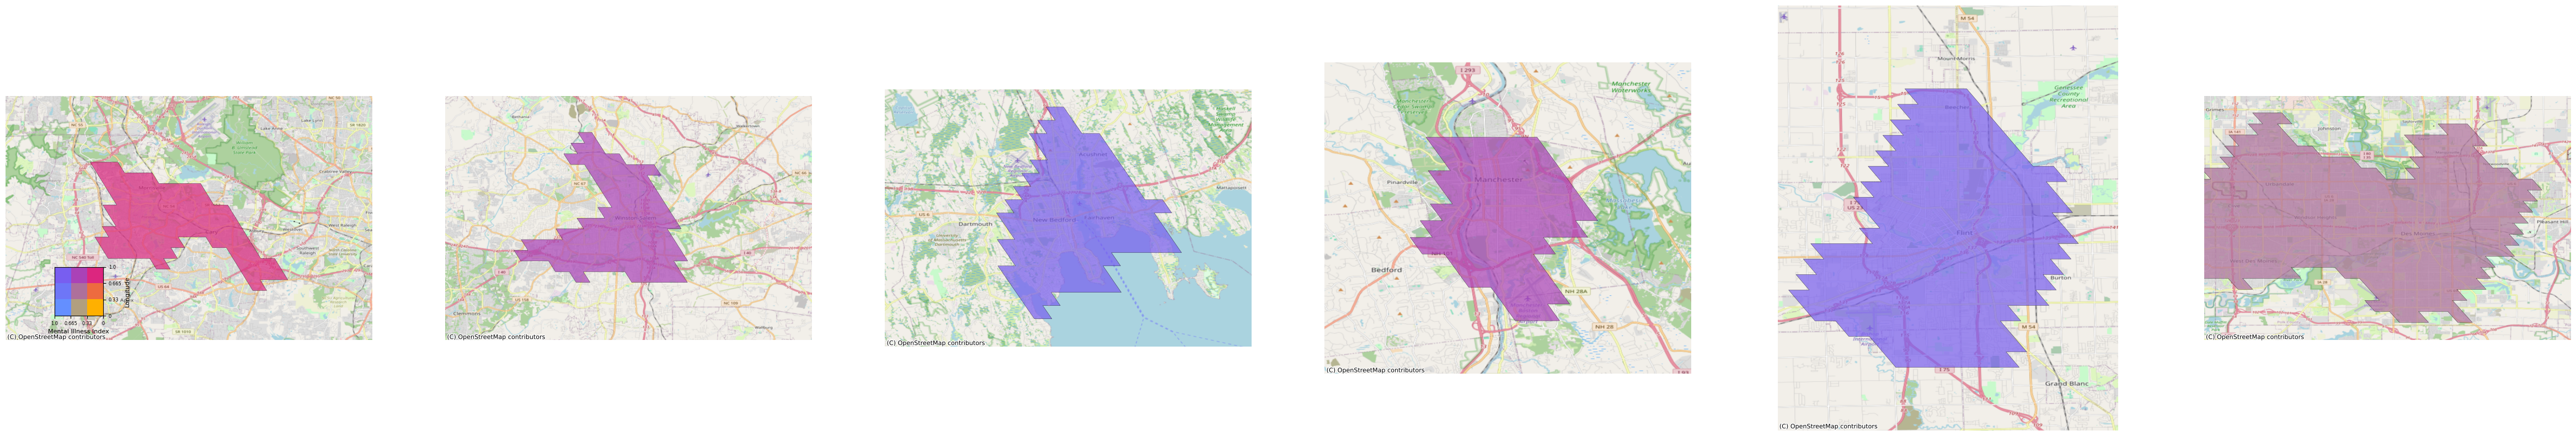

In [86]:
fig,ax = plt.subplots(1,6,figsize=(60,10))
ax1, ax2, ax3, ax4, ax5, ax6 = ax
map.matplotlib_map(ax1, df1, 'c1_en', 'c2_mh', colorlist,xlim=[-78.95,-78.65],ylim=[35.7,35.9],alpha=0.7, edge_color="black", line_width=0.35, figsize=(20, 10))
map.matplotlib_map(ax2, df2, 'c1_en', 'c2_mh', colorlist,xlim=[-80.4,-80.1],ylim=[36.0,36.2],alpha=0.7, edge_color="black", line_width=0.35, figsize=(20, 10))
map.matplotlib_map(ax3, df3, 'c1_en', 'c2_mh', colorlist,xlim=[-71.05,-70.8],ylim=[41.55,41.725],alpha=0.7, edge_color="black", line_width=0.35, figsize=(20, 10))
map.matplotlib_map(ax4, df4, 'c1_en', 'c2_mh', colorlist,xlim=[-71.55,-71.35],ylim=[42.89,43.06],alpha=0.7, edge_color="black", line_width=0.35, figsize=(20, 10))
map.matplotlib_map(ax5, df5, 'c1_en', 'c2_mh', colorlist,xlim=[-83.8,-83.6],ylim=[42.9,43.15],alpha=0.7, edge_color="black", line_width=0.35, figsize=(20, 10))
map.matplotlib_map(ax6, df6, 'c1_en', 'c2_mh', colorlist,xlim=[-93.8,-93.5],ylim=[41.5,41.7],alpha=0.7, edge_color="black", line_width=0.35, figsize=(20, 10))


map.bicolor_legend(
    ax1,
    colorlist,
    percentile = percentile,
    legend_position=[0.1, 0.1, 0.2, 0.2],
    tick_fontsize=6,
    label_fontsize=8,
    x_label="Mental Illness Index",
    y_label="Longitude"   
)

map.set_off_axis(ax1)
map.set_off_axis(ax2)
map.set_off_axis(ax3)
map.set_off_axis(ax4)
map.set_off_axis(ax5)
map.set_off_axis(ax6)
